<a href="https://colab.research.google.com/github/alex-smith-uwec/CS-420/blob/main/BeyondSoftmaxRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical


In [ ]:
# Generate non-linear data
X, y = make_moons(n_samples=3000, noise=0.2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

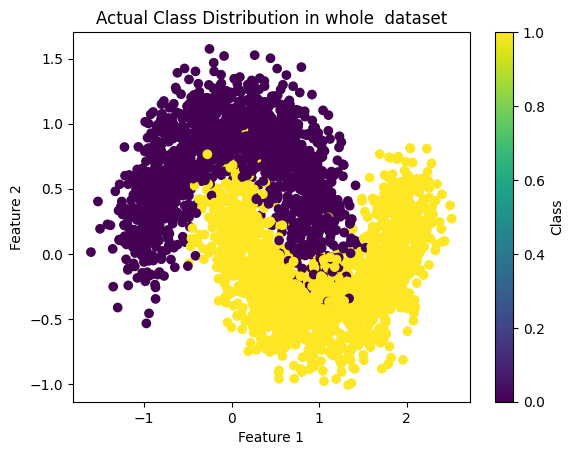

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Actual Class Distribution in whole  dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class')
plt.show()

The code cell below is the simple model for softmax regression where we explicitly encoded the basic gradient:

            y_one_hot = np.eye(n_classes)[y]
            dw = np.dot(X.T, (probabilities - y_one_hot)) / m
            db = np.sum(probabilities - y_one_hot, axis=0) / m
In another code cell below we use softmax regression with stochastic average gradient, which is a refinement of our basic gradient.

In [ ]:
#Define the softmax function
def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)
# Implement a simple model for softmax regression
#This is the model where the gradient is coded. See notebook SoftmaxRegression
#In a few code cells below, we will replace this with a Keras model which is the same,
#excecpt that it replaces our gradient optimizer by an improvement called
#stochastic gradient descent" (SGD)

class SoftmaxRegression:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.losses = []


    def fit(self, X, y, n_classes, lr=0.01, epochs=1000):
        m, n_features = X.shape
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        for _ in range(epochs):
            scores = np.dot(X, self.weights) + self.bias
            probabilities = softmax(scores)

            # Compute the loss. This can be
            # commented out if we don't want to graph loss
            y_one_hot = np.eye(n_classes)[y]
            loss = -np.mean(np.sum(y_one_hot * np.log(probabilities), axis=1))
            self.losses.append(loss)

            # Compute the gradient
            y_one_hot = np.eye(n_classes)[y]
            dw = np.dot(X.T, (probabilities - y_one_hot)) / m
            db = np.sum(probabilities - y_one_hot, axis=0) / m

            # Update the weights and bias
            self.weights -= lr * dw
            self.bias -= lr * db

    def predict(self, X):
        scores = np.dot(X, self.weights) + self.bias
        probabilities = softmax(scores)
        return np.argmax(probabilities, axis=1)


Accuracy: 0.7966666666666666


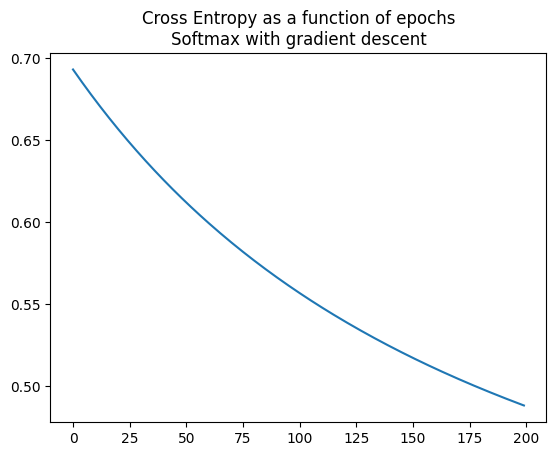

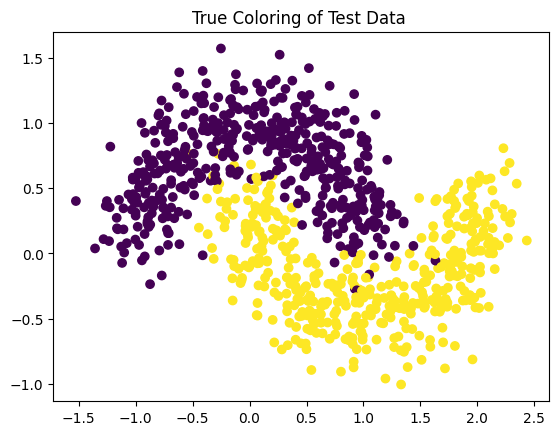

In [ ]:
# Train the model
model_0 = SoftmaxRegression()
model_0.fit(X_train, y_train, n_classes=2,epochs=200)

# Step 5: Make predictions and evaluate the model
y_pred = model_0.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Optional: Plotting the results
plt.plot(model_0.losses)
plt.title("Cross Entropy as a function of epochs\nSoftmax with gradient descent")
plt.show()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title("True Coloring of Test Data ")
plt.show()


Next we introduce a variant of our SoftmaxRegression. This variant named model_A comes from Keras.  The algorithm model_A uses stochastic gradient descent, which is a refinement of our basic gradient descent.

We also introduce a neutral network with one hidden layer named model_B.
The idea is that the hidden layer will add compexity to the model, thereby improving the perforance on the moon blobs.

In [ ]:
#  Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model_A = Sequential([
    Dense(num_classes, input_shape=(X_train_scaled.shape[1],), activation='softmax')
])

## Compile the model with the correct loss function
model_A.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with one-hot encoded labels
history_A = model_A.fit(X_train_scaled, y_train_categorical, epochs=200, verbose=0)

# Evaluate the model
_, accuracy_softmax = model_A.evaluate(X_test_scaled, y_test_categorical, verbose=0)
accuracy_softmax


0.8644444346427917

In [ ]:
model_B = Sequential([
    Dense(10, input_shape=(2,), activation='relu'),
    Dense(1, activation='sigmoid')
])

model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_B=model_B.fit(X_train_scaled, y_train, epochs=200, verbose=0)
_, accuracy_nn = model_B.evaluate(X_test_scaled, y_test, verbose=0)


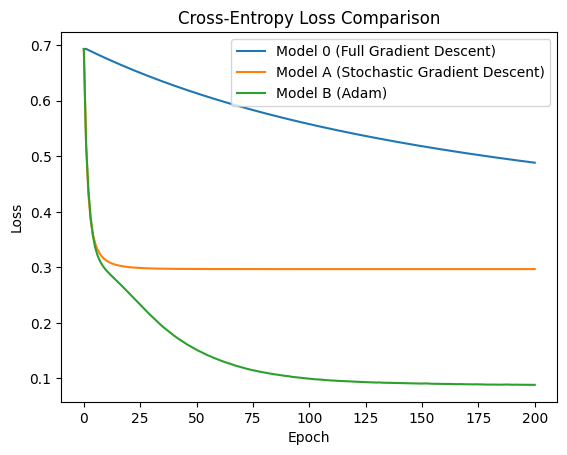

In [ ]:
##Cross entropy starts at ln(2)=0.693. Keras history might be starting after one epoch or something similar.
#So we insert a value for the start, so all three curves start at the same point.
model_0.losses.insert(0, 0.693)
history_A.history['loss'].insert(0, 0.693)
history_B.history['loss'].insert(0, 0.693)

plt.plot(model_0.losses, label='Model 0 (Full Gradient Descent)')
plt.plot(history_A.history['loss'], label='Model A (Stochastic Gradient Descent)')
plt.plot(history_B.history['loss'], label='Model B (Adam)')

plt.title('Cross-Entropy Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
accuracy, accuracy_softmax, accuracy_nn

(0.7966666666666666, 0.8644444346427917, 0.9688888788223267)

29/29 [==============================] - 0s 1ms/step


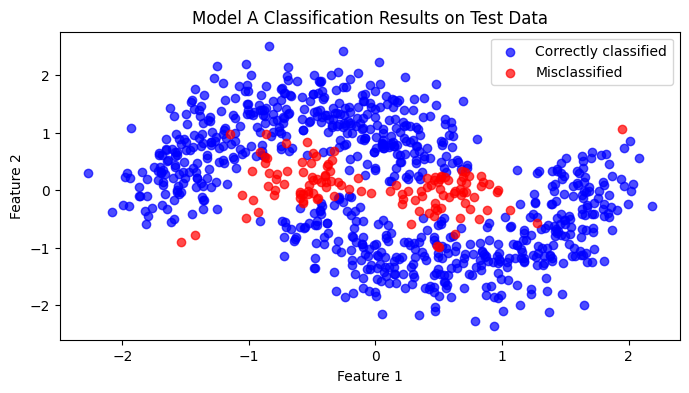

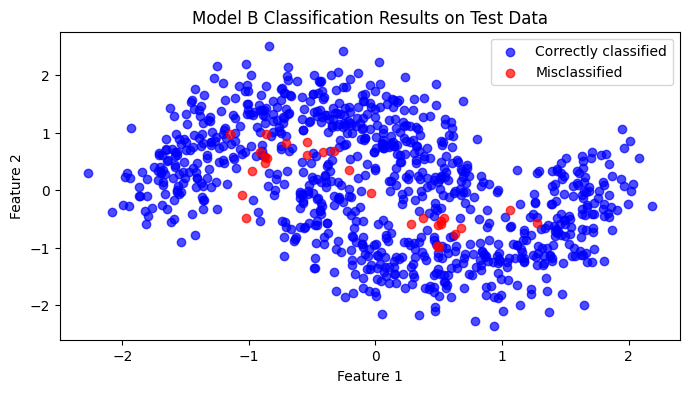

In [ ]:
# Predictions from model A
y_pred_A = model_A.predict(X_test_scaled)
# Convert predictions to label format
y_pred_A = np.argmax(y_pred_A, axis=1)

# Predictions from model B
y_pred_B = model_B.predict(X_test_scaled)
# Convert predictions to label format
y_pred_B = (y_pred_B > 0.5).astype('int32').reshape(-1)

# Function to plot
def plot_results(X, y_true, y_pred, title):
    correct = y_true == y_pred
    incorrect = ~correct

    plt.figure(figsize=(8, 4))
    plt.scatter(X[correct, 0], X[correct, 1], c='blue', label='Correctly classified', alpha=0.7)
    plt.scatter(X[incorrect, 0], X[incorrect, 1], c='red', label='Misclassified', alpha=0.7)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Plot for model A
plot_results(X_test_scaled, y_test, y_pred_A, 'Model A Classification Results on Test Data')

# Plot for model B
plot_results(X_test_scaled, y_test, y_pred_B, 'Model B Classification Results on Test Data')


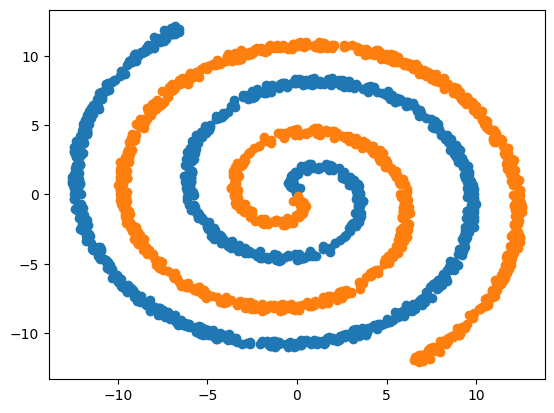

In [ ]:
def generate_spirals(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    return np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))), np.hstack((np.zeros(n_points), np.ones(n_points)))

X, y = generate_spirals(1000)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1])
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1])
plt.show()

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_classes = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

In [ ]:
#  Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model_A = Sequential([
    Dense(num_classes, input_shape=(X_train_scaled.shape[1],), activation='softmax')
])

## Compile the model with the correct loss function
model_A.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with one-hot encoded labels
history_A = model_A.fit(X_train_scaled, y_train_categorical, epochs=100, verbose=0)

# Evaluate the model
_, accuracy_softmax = model_A.evaluate(X_test_scaled, y_test_categorical, verbose=0)
accuracy_softmax


0.5883333086967468

In [ ]:
model_B = Sequential([
    Dense(10, input_shape=(2,), activation='relu'),
    Dense(1, activation='sigmoid')
])

model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_B=model_B.fit(X_train_scaled, y_train, epochs=100, verbose=0)
_, accuracy_nn = model_B.evaluate(X_test_scaled, y_test, verbose=0)


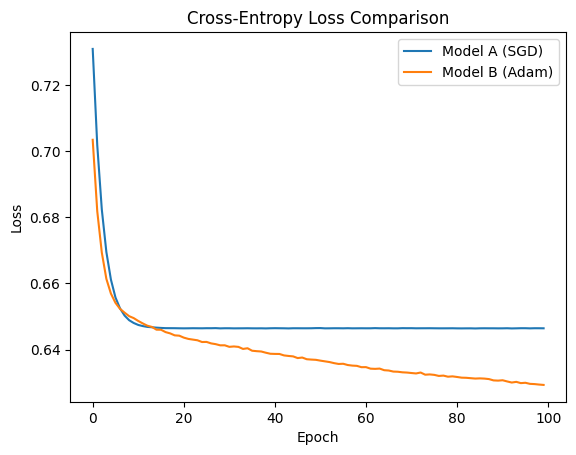

In [ ]:
plt.plot(history_A.history['loss'], label='Model A (SGD)')
plt.plot(history_B.history['loss'], label='Model B (Adam)')

plt.title('Cross-Entropy Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
accuracy_softmax, accuracy_nn

(0.5883333086967468, 0.5633333325386047)

19/19 [==============================] - 0s 2ms/step


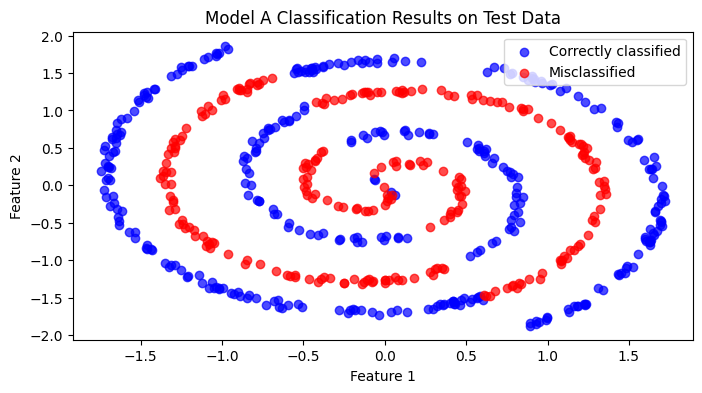

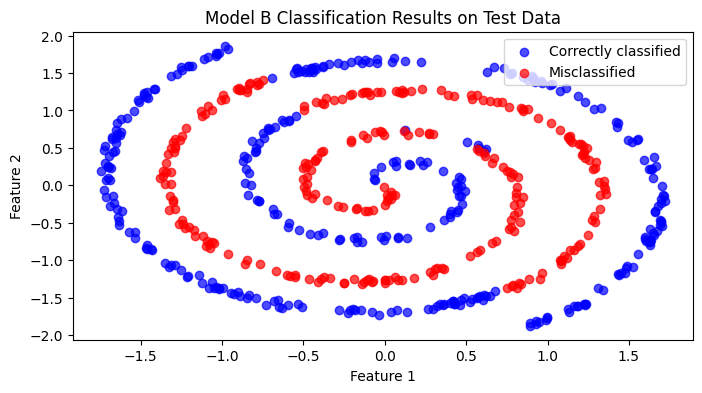

In [ ]:
# Predictions from model A
y_pred_A = model_A.predict(X_test_scaled)
# Convert predictions to label format
y_pred_A = np.argmax(y_pred_A, axis=1)

# Predictions from model B
y_pred_B = model_B.predict(X_test_scaled)
# Convert predictions to label format
y_pred_B = (y_pred_B > 0.5).astype('int32').reshape(-1)

# Function to plot
def plot_results(X, y_true, y_pred, title):
    correct = y_true == y_pred
    incorrect = ~correct

    plt.figure(figsize=(8, 4))
    plt.scatter(X[correct, 0], X[correct, 1], c='blue', label='Correctly classified', alpha=0.7)
    plt.scatter(X[incorrect, 0], X[incorrect, 1], c='red', label='Misclassified', alpha=0.7)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Plot for model A
plot_results(X_test_scaled, y_test, y_pred_A, 'Model A Classification Results on Test Data')

# Plot for model B
plot_results(X_test_scaled, y_test, y_pred_B, 'Model B Classification Results on Test Data')


In [ ]:
# Neural Network Model with additional hidden layers
model_C = Sequential([
    Dense(10, input_shape=(2,), activation='relu'),
    Dense(50, activation='relu'),  # Additional hidden layer
    Dense(10, activation='relu'),  # Another additional hidden layer
    Dense(1, activation='sigmoid')
])

model_C.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_C.fit(X_train_scaled, y_train, epochs=100, verbose=0)
_, accuracy_nn = model_C.evaluate(X_test_scaled, y_test, verbose=0)

# Output the model's accuracy
print("Neural Network Accuracy:", accuracy_nn)

Neural Network Accuracy: 0.9333333373069763


19/19 [==============================] - 0s 2ms/step


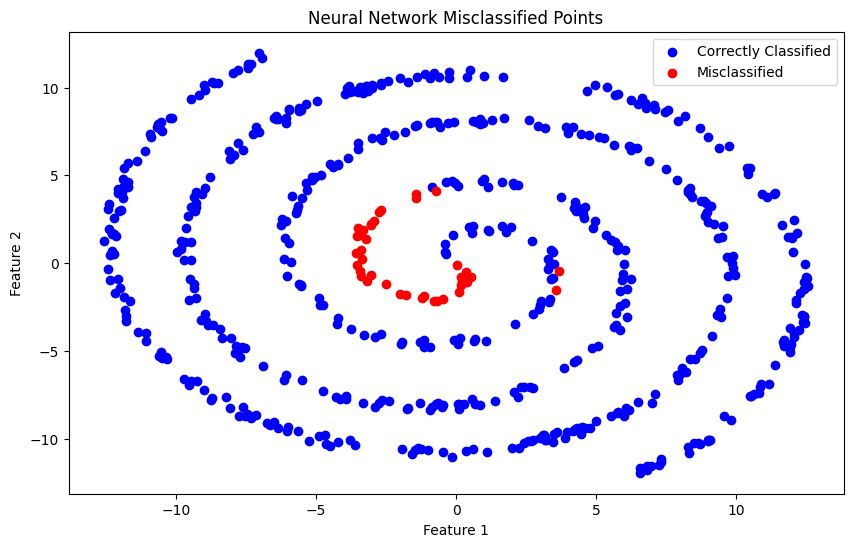

In [ ]:
# Get predictions from neural network
y_pred_nn_prob = model_C.predict(X_test_scaled)  # Predicted probabilities
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()  # Convert probabilities to class labels

# Plotting for softmax regression
# plot_misclassified(X_test, y_test, y_pred_softmax, 'Softmax Regression Misclassified Points')

# Plotting for neural network
plot_misclassified(X_test, y_test, y_pred_nn, 'Neural Network Misclassified Points')


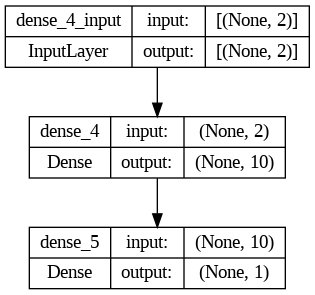

In [ ]:
plot_model(model_B, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
plot_model(model_A, to_file='model_A_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model_B, to_file='model_B_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model_C, to_file='model_C_plot.png', show_shapes=True, show_layer_names=True)

None

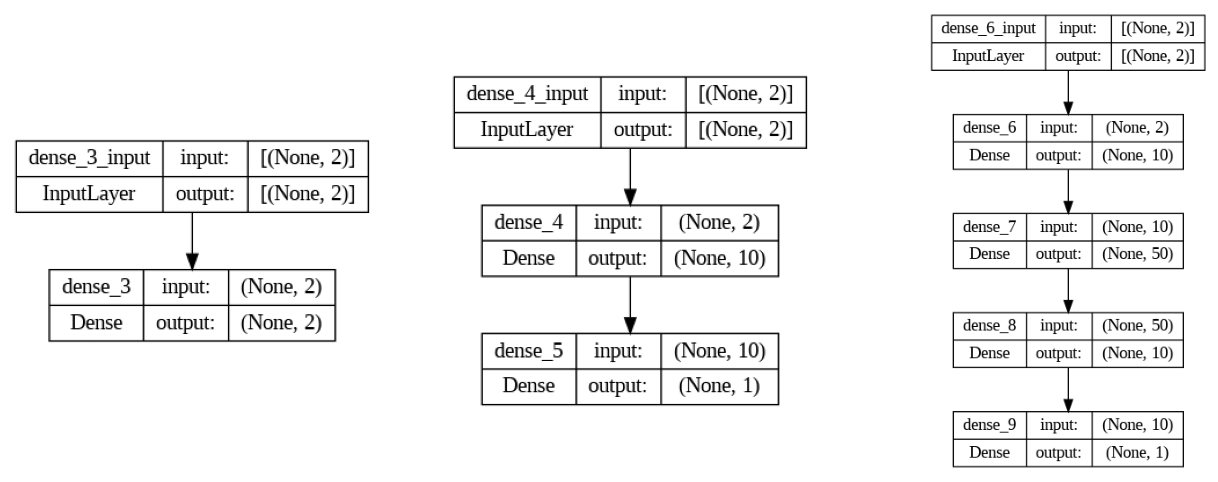

In [ ]:
img_A = mpimg.imread('model_A_plot.png')
img_B = mpimg.imread('model_B_plot.png')
img_C = mpimg.imread('model_C_plot.png')

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_A)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_B)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_C)
plt.axis('off')

plt.show()

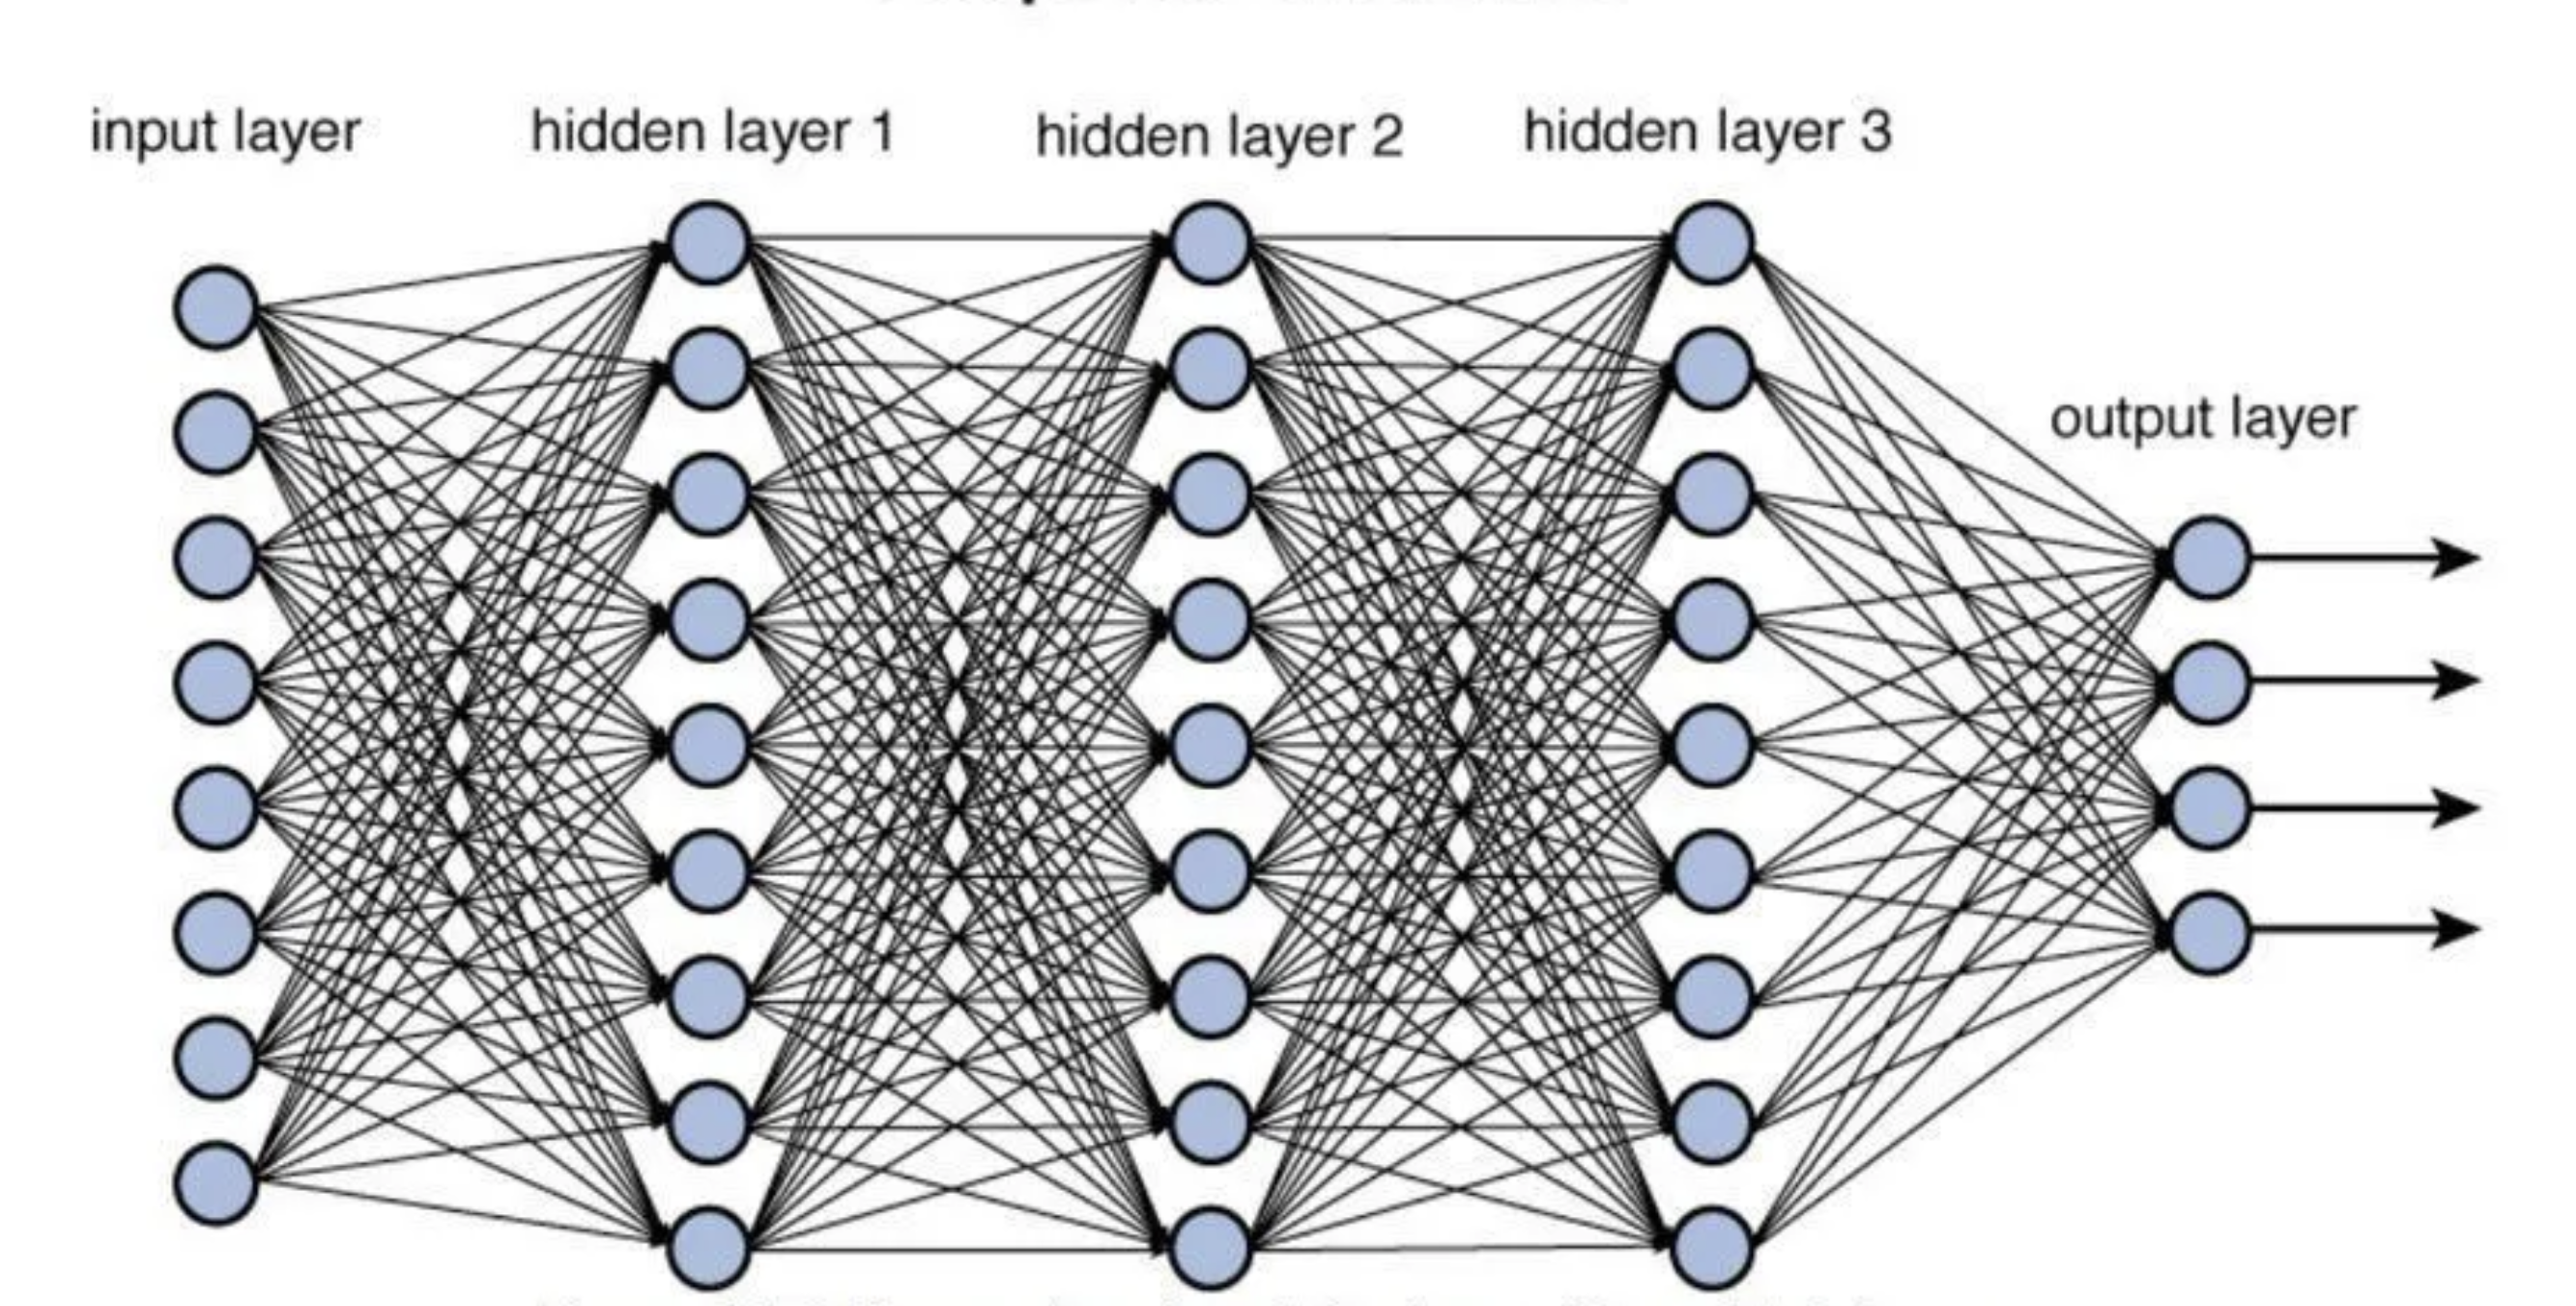